### 0. Import Libraries (only an overview)

In [305]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix

### 1. Create a DataFrame

- Connection between MySQL and Python
- Only selecting Status A and B

In [306]:
import getpass
password = getpass.getpass()

········


In [307]:
connection_string = "mysql+pymysql://root:" + password + '@localhost/bank'
engine = create_engine(connection_string)

query = """
SELECT 
    t.type,
    t.operation,
    t.amount AS t_amount,
    t.balance,
    t.k_symbol,
    l.amount AS l_amount,
    l.duration,
    l.payments,
    l.status
FROM
    trans t
        LEFT JOIN
    loan l ON t.account_id = l.account_id
where l.status in ('A', 'B');
"""

In [308]:
data = pd.read_sql_query(query, engine)

In [309]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A


### 2. EDA - exploratory the data - Part 1

- check the datatypes and the NaN-Values

*** Results for Wrangling the Data (next step)***
- no NaN in the DataFrame
- convert datatype of the column 'duration' into objective
- cleaning the columns 'operation' and 'k_symbols'
- no changes in the columns 'status'and 'type'

In [310]:
data.shape

(74364, 9)

In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  int64  
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 5.1+ MB


In [312]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

- check the content of the categorical columns

In [313]:
data['operation'].value_counts()

VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64

In [314]:
data['k_symbol'].value_counts()

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [315]:
data['type'].value_counts()

VYDAJ     44075
PRIJEM    27660
VYBER      2629
Name: type, dtype: int64

In [316]:
data['status'].value_counts()

A    64599
B     9765
Name: status, dtype: int64

### 3. Data Wrangling 
***the stepts are the results from the EDA (step before)***

- convert datatype of the column "duration" into objective

In [317]:
data['duration'] = data['duration'].astype('object')

In [318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  object 
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 5.1+ MB


In [319]:
data['duration'].value_counts()

12    28761
24    25155
36    14110
48     4721
60     1617
Name: duration, dtype: int64

***cleaning the column 'operation' ***

- change 'PREVOD NA UCET' and 'PREVOD Z UCTU' into 'prevod' 
- change 'whitespace' into 'unknown'
- change 'VYBER KARTOU' and 'VYBER' into 'vyber'
- change 'VKLAD' into 'vklad'

In [320]:
def col_operation(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

In [321]:
data['operation'] = data['operation'].apply(col_operation)

In [322]:
data['operation'].value_counts()

vyber      35057
unknown    14646
prevod     14136
vklad      10525
Name: operation, dtype: int64

***cleaning the column 'k_symbol' ***
- replace the '' and 'whitespace' -> 'unknown'

In [323]:
def col_k_symbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [324]:
data['k_symbol'] = data['k_symbol'].apply(col_k_symbol)

In [325]:
data['k_symbol'].value_counts()

unknown        38971
UROK           14646
SLUZBY         11306
SIPO            5081
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

- cleaning the column k_symbol -> no unknown data
- No removing further rows from the column, because the data set should not be further minimized to have enough for the Test-Training-Model

In [326]:
data = data[~data['k_symbol'].isin(['unknown'])]

In [327]:
data['k_symbol'].value_counts()

UROK           14646
SLUZBY         11306
SIPO            5081
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

### 4. EDA - exploratory the data - Part 2

- checking the numerical columns

In [328]:
corr_matrix = data.corr()

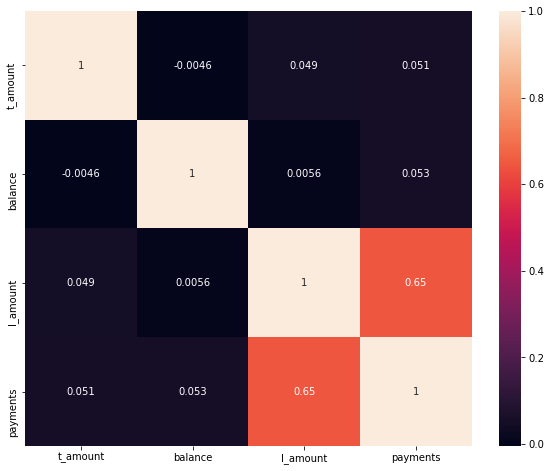

In [329]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

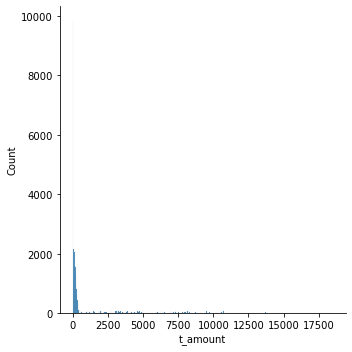

In [330]:
sns.displot(data['t_amount'])
plt.show()

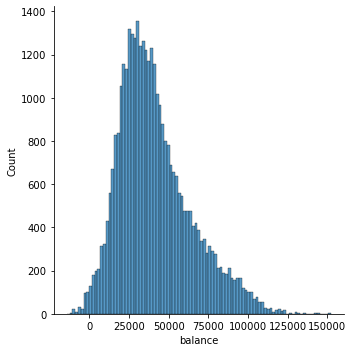

In [331]:
sns.displot(data['balance'])
plt.show()

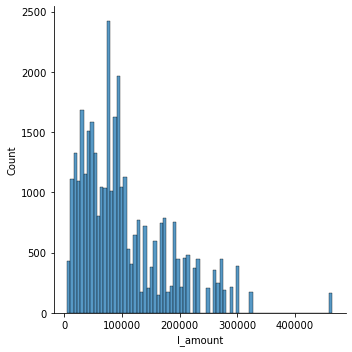

In [332]:
sns.displot(data['l_amount'])
plt.show()

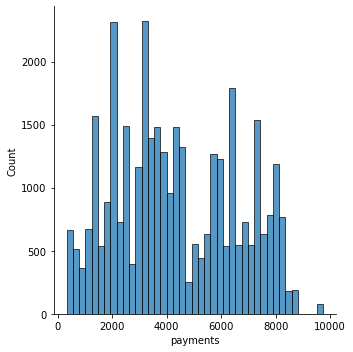

In [333]:
sns.displot(data['payments'])
plt.show()

In [334]:
data.describe()

,t_amount,balance,l_amount,payments
count,35393.000000,35393.000000,35393.000000,35393.000000
mean,1257.234425,41341.166745,104260.086232,4331.672704
std,2518.523227,22902.843613,76152.096499,2225.434167
min,0.000000,-14137.200000,4980.000000,319.000000
25%,14.600000,25086.400000,46320.000000,2523.000000
50%,136.700000,37222.700000,86184.000000,3918.000000
75%,387.500000,53870.400000,141648.000000,6315.000000
max,18500.000000,152016.000000,464520.000000,9736.000000


- checking the categorical columns

In [335]:
cols_cat = list(data.select_dtypes(include=['object']).columns)

Frequency analysis of column:  type
Frequency analysis of column:  operation
Frequency analysis of column:  k_symbol
Frequency analysis of column:  duration
Frequency analysis of column:  status


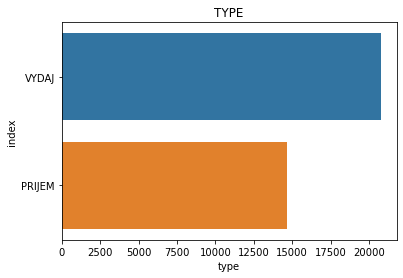

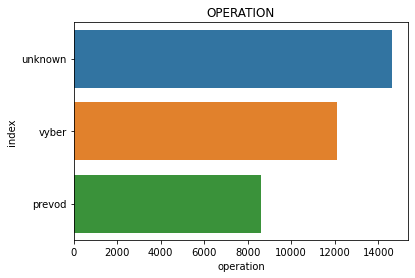

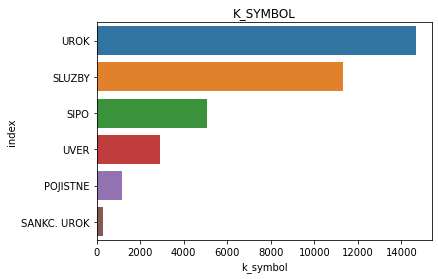

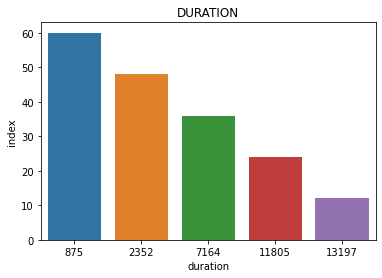

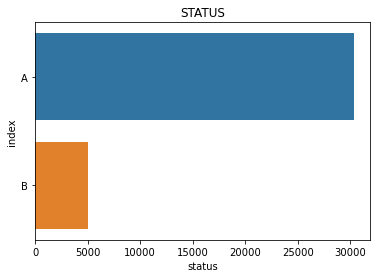

<Figure size 432x288 with 0 Axes>

In [336]:
for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print

### 5. Pre-Processing

***built two subsets***
1. subset for numerical data
2. subset for categorical data

In [337]:
num = data.select_dtypes(include = np.number)
num

,t_amount,balance,l_amount,payments
9,17.0,21078.0,76908,6409.0
11,110.2,45659.2,79608,3317.0
12,0.8,6182.8,41904,3492.0
42,21.6,29015.6,65184,5432.0
43,102.0,36270.0,76908,6409.0
...,...,...,...,...
74359,221.3,48019.4,131292,3647.0
74360,227.6,108432.0,168984,7041.0
74361,235.7,53703.3,182628,5073.0
74362,293.0,85131.6,274740,4579.0


In [338]:
cat = data.select_dtypes(include = np.object)
cat

<ipython-input-338-a2417216adda>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = data.select_dtypes(include = np.object)


,type,operation,k_symbol,duration,status
9,PRIJEM,unknown,UROK,12,B
11,PRIJEM,unknown,UROK,24,A
12,PRIJEM,unknown,UROK,12,A
42,PRIJEM,unknown,UROK,12,A
43,PRIJEM,unknown,UROK,12,B
...,...,...,...,...,...
74359,PRIJEM,unknown,UROK,36,A
74360,PRIJEM,unknown,UROK,24,B
74361,PRIJEM,unknown,UROK,36,A
74362,PRIJEM,unknown,UROK,60,A


- The range between the numerical data is too big. These have to be normalized.

In [339]:
transformer = Normalizer()
transformer.fit(num)
num_normalized = transformer.transform(num)

In [340]:
num_new = pd.DataFrame(num_normalized, columns=num.columns)

In [341]:
num_new.head()

,t_amount,balance,l_amount,payments
0,0.000212,0.263471,0.961335,0.080111
1,0.001200,0.497201,0.866882,0.036120
2,0.000019,0.145473,0.985945,0.082162
3,0.000302,0.405491,0.910942,0.075912
4,0.001196,0.425341,0.901906,0.075159


- The categorical data will be encoded (= 0 / 1).
- At first: Drop the column 'status'. That is our dependent variable.

In [342]:
categorical = pd.get_dummies(cat, columns=['type', 'operation', 'k_symbol' ,'duration', 'status'], drop_first=True)
categorical.head()

,type_VYDAJ,operation_unknown,operation_vyber,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_UVER,duration_24,duration_36,duration_48,duration_60,status_B
9,0,1,0,0,0,0,1,0,0,0,0,0,1
11,0,1,0,0,0,0,1,0,1,0,0,0,0
12,0,1,0,0,0,0,1,0,0,0,0,0,0
42,0,1,0,0,0,0,1,0,0,0,0,0,0
43,0,1,0,0,0,0,1,0,0,0,0,0,1


- check the numbers of the rows (avoid missmatch)

In [343]:
len(num), len(categorical), len(data)

(35393, 35393, 35393)

### 6. Apply the model

1. Our Y-value is the 'status'. The Y-value must be removed from the dataset categorical.

In [344]:
Y = categorical['status_B']

In [345]:
categorical['status_B'].value_counts()

0    30346
1     5047
Name: status_B, dtype: int64

In [346]:
categorical_new=categorical.drop(['status_B'], axis=1)
categorical

,type_VYDAJ,operation_unknown,operation_vyber,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_UVER,duration_24,duration_36,duration_48,duration_60,status_B
9,0,1,0,0,0,0,1,0,0,0,0,0,1
11,0,1,0,0,0,0,1,0,1,0,0,0,0
12,0,1,0,0,0,0,1,0,0,0,0,0,0
42,0,1,0,0,0,0,1,0,0,0,0,0,0
43,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74359,0,1,0,0,0,0,1,0,0,1,0,0,0
74360,0,1,0,0,0,0,1,0,1,0,0,0,1
74361,0,1,0,0,0,0,1,0,0,1,0,0,0
74362,0,1,0,0,0,0,1,0,0,0,0,1,0


2. cerate an array with the normalized data (numerical and categorical (without 'status_B'). That are our x-values.

In [347]:
X = np.concatenate((num_new,categorical_new), axis=1)

#### Create the Test-Training-Model

In [349]:
X_train, X_test, y_train, y_test =train_test_split(X, Y, test_size= 0.4, random_state=40)

#### Apply the model

In [350]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400, multi_class='ovr').fit(X_train, y_train)

### 7. Evaluate the accuracy and the test

In [351]:
predictions = classification.predict(X_test)

In [352]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [353]:
accuracy_score(y_test, predictions)

0.8762537081508688

#### Visualization of the Accuracy (ROC, AUC)

In [354]:
probs = classification.predict_proba(X_test)
preds =probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7912480790946191


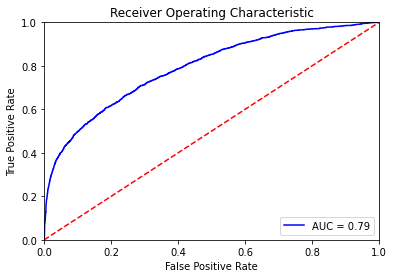

In [355]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

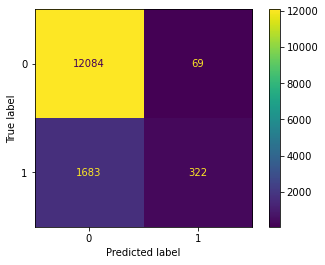

In [356]:
accuracy_score(y_test,predictions)
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()

*** The Type II-Error/Mistake of 1683 is to big. The accuracy is not good enough. The next steps leads into the direction of data imbalanced. The goal is to detect the data imbalanced and to corect em with the goal to improve the model.***